# Introduction

Dans ce chapitre d'introduction, nous allons présenter un premier réseau neuronal appelé
le Perceptron.
Ce modèle est un réseau neuronal constitué d'un seul neurone, et nous l'utiliserons ici pour introduire des concepts-clés que nous détaillerons plus tard dans le cours.

In [1]:
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from notebook_utils import prepare_notebook_graphics
prepare_notebook_graphics()

## Un premier modèle : le perceptron

Dans la terminologie des réseaux de neurones, un neurone est une fonction paramétrée qui
prend un vecteur $\mathbf{x}$ en entrée et sort une valeur unique $a$ comme suit :

$$
    a = \varphi(\underbrace{\mathbf{w} \mathbf{x} + b}_{o}) ,
$$

où les paramètres du neurone sont ses poids stockés dans $\mathbf{w}$.
et un terme de biais $b$, et $\varphi$ est une fonction d'activation qui est choisie
a priori
(nous y reviendrons plus en détail plus tard dans le cours) :

```{tikz}
    \node[draw,circle,minimum size=25pt,inner sep=0pt] (x) at (0,0) {$o$};
    \node[draw,circle,fill=green,fill opacity=.2,text opacity=1.,minimum size=25pt,inner sep=0pt] (a) at (2, 0) {$\tiny a$};

	\node[draw,circle,fill=blue,fill opacity=.2,text opacity=1.,minimum size=25pt,inner sep=0pt] (x0) at (-2, 2) {$\tiny x_0$};
	\node[draw,circle,fill=blue,fill opacity=.2,text opacity=1.,minimum size=25pt,inner sep=0pt] (x1) at (-2, 1) {$\tiny x_1$};
	\node[draw,circle,fill=blue,fill opacity=.2,text opacity=1.,minimum size=25pt,inner sep=0pt] (x2) at (-2, 0) {$\tiny x_2$};
	\node[draw,circle,fill=blue,fill opacity=.2,text opacity=1.,minimum size=25pt,inner sep=0pt] (x3) at (-2, -1) {$\tiny x_3$};
	\node[draw,circle,fill=blue,fill opacity=.2,text opacity=1.,minimum size=25pt,inner sep=0pt] (b) at (-2, -2) {$\tiny +1$};

	\draw[->, thick] (x0) to[out=0,in=120] node [midway, sloped, above=-2] {$w_0$} (x);
	\draw[->, thick] (x1) to[out=0,in=150] node [midway, sloped, above=-2] {$w_1$} (x);
	\draw[->, thick] (x2) to[out=0,in=180] node [midway, sloped, above=-2] {$w_2$} (x);
	\draw[->, thick] (x3) to[out=0,in=210] node [midway, sloped, above=-2] {$w_3$} (x);
	\draw[->, thick] (b) to[out=0,in=240] node [midway, sloped, above=-2] {$b$} (x);

	\draw[->, thick] (x) to node [midway,above=-0.1cm] {$\varphi$} (a);
```

Un modèle constitué d'un seul neurone est appelé perceptron.

## Optimisation

Les modèles présentés dans ce document ont pour but de résoudre des problèmes de prédiction
dans lesquels l'objectif est de trouver des valeurs de paramètres "suffisamment bonnes" pour le modèle en jeu
compte tenu de données observées.

Le problème de la recherche de telles valeurs de paramètres est appelé optimisation.
L'apprentissage profond (ou _deep learning_) fait un usage intensif d'une famille spécifique de stratégies d'optimisation appelée **descente gradiente**.

(sec:boston)=
### Descente de gradient

Pour se faire une idée de la descente de gradient, supposons que l'on nous donne le jeu de données suivant sur les prix de l'immobilier :

In [2]:
import pandas as pd

boston = pd.read_csv("../data/boston.csv")[["RM", "PRICE"]]
boston

,RM,PRICE
0,6.575,24.0
1,6.421,21.6
2,7.185,34.7
3,6.998,33.4
4,7.147,36.2
...,...,...
501,6.593,22.4
502,6.120,20.6
503,6.976,23.9
504,6.794,22.0


Dans notre cas, nous essaierons (pour commencer) de prédire la valeur cible `"PRICE"` de ce jeu de données, qui est la valeur médiane des maisons occupées par leur propriétaire en milliers de dollars en fonction du nombre moyen de pièces par logement `"RM"` :

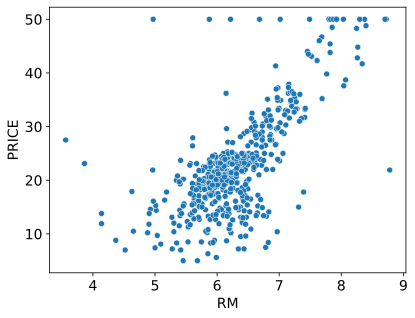

In [3]:
sns.scatterplot(data=boston, x="RM", y="PRICE");

```{sidebar} Une courte note sur ce modèle

Dans la terminologie du Perceptron, ce modèle :
* n'a pas de fonction d'activation (_i.e._ $\varphi$ est la fonction d'identité)
* n'a pas de biais (_i.e._ $b$ est fixé à $0$, il n'est pas appris)
```

Supposons que nous ayons une approche naïve dans laquelle notre modèle de prédiction est linéaire sans biais, c'est-à-dire que pour une entrée donnée $x_i$ la sortie prédite est
calculée comme suit :

$$
    \hat{y_i} = w x_i
$$

où $w$ est le seul paramètre de notre modèle.

Supposons en outre que la quantité que nous cherchons à minimiser
(notre objectif, également appelé fonction de perte) est :

$$
    \mathcal{L}(w) = \sum_i \left(\hat{y_i} - y_i\right)^2
$$

où $y_i$ est la valeur cible associée au $i$-ème échantillon de jeu de données.

Examinons cette quantité en fonction de $w$ :

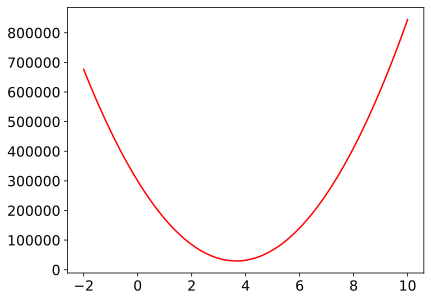

In [4]:
import numpy as np

def loss(w, x, y):
    w = np.array(w)
    return np.sum(
        (w[:, None] * x.to_numpy()[None, :] - y.to_numpy()[None, :]) ** 2,
        axis=1
    )

w = np.linspace(-2, 10, num=100)

x = boston["RM"]
y = boston["PRICE"]
plt.plot(w, loss(w, x, y), "r-");

Ici, il semble qu'une valeur de $w$ autour de 4 devrait être un bon choix.
Cette méthode (générer de nombreuses valeurs pour le paramètre et calculer la perte pour
chaque valeur) ne peut pas s'adapter aux modèles qui ont beaucoup de paramètres, donc nous allons
donc essayer autre chose.

Supposons que nous ayons accès, à chaque fois que nous choisissons une valeur candidate pour $w$,
à la fois à la perte $\mathcal{L}$ et aux informations sur la façon dont $\mathcal{L}$ varie,
localement.
Nous pourrions, dans ce cas, calculer une nouvelle valeur candidate pour $w$ en nous déplaçant à partir de la valeur candidate précédente dans la direction de la descente la plus raide.
C'est l'idée de base de l'algorithme de descente du gradient qui, à partir d'un candidat initial $w_0$, calcule itérativement de nouveaux candidats comme :

$$
    w_{t+1} = w_t - \rho \left. \frac{\partial \mathcal{L}}{\partial w} \right|_{w=w_t}
$$

où $\rho$ est un hyper-paramètre (appelé taux d'apprentissage)
qui contrôle la taille des pas à effectuer, et
$\left. \frac{\partial \mathcal{L}}{\partial w} \right|_{w=w_t}$ est le
gradient de
$\mathcal{L}$ par rapport à $w$, évalué en $w=w_t$.
Comme vous pouvez le voir, la direction de la descente la plus raide est l'opposé de la direction indiquée par le gradient (et cela vaut aussi pour les paramètres vectoriels).

Ce processus est répété jusqu'à la convergence, comme l'illustre la figure suivante :

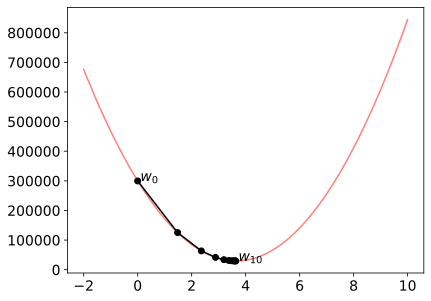

In [5]:
rho = 1e-5

def grad_loss(w_t, x, y):
    return np.sum(
        2 * (w_t * x - y) * x
    )


ww = np.linspace(-2, 10, num=100)
plt.plot(ww, loss(ww, x, y), "r-", alpha=.5);

w = [0.]
for t in range(10):
    w_update = w[t] - rho * grad_loss(w[t], x, y)
    w.append(w_update)

plt.plot(w, loss(w, x, y), "ko-")
plt.text(x=w[0]+.1, y=loss([w[0]], x, y), s="$w_{0}$")
plt.text(x=w[10]+.1, y=loss([w[10]], x, y), s="$w_{10}$");

Qu'obtiendrions-nous si nous utilisions un taux d'apprentissage plus faible ?

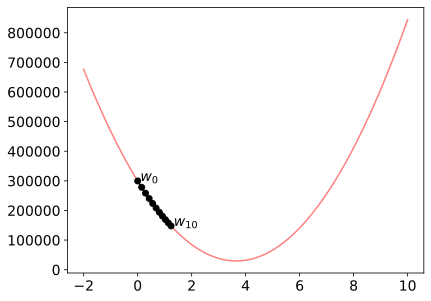

In [6]:
rho = 1e-6

ww = np.linspace(-2, 10, num=100)
plt.plot(ww, loss(ww, x, y), "r-", alpha=.5);

w = [0.]
for t in range(10):
    w_update = w[t] - rho * grad_loss(w[t], x, y)
    w.append(w_update)

plt.plot(w, loss(w, x, y), "ko-")
plt.text(x=w[0]+.1, y=loss([w[0]], x, y), s="$w_{0}$")
plt.text(x=w[10]+.1, y=loss([w[10]], x, y), s="$w_{10}$");

Cela prendrait certainement plus de temps pour converger.
Mais attention, un taux d'apprentissage plus élevé n'est pas toujours une bonne idée :

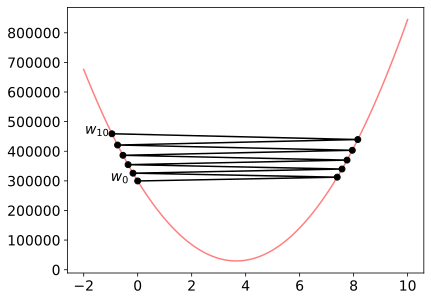

In [7]:
rho = 5e-5

ww = np.linspace(-2, 10, num=100)
plt.plot(ww, loss(ww, x, y), "r-", alpha=.5);

w = [0.]
for t in range(10):
    w_update = w[t] - rho * grad_loss(w[t], x, y)
    w.append(w_update)

plt.plot(w, loss(w, x, y), "ko-")
plt.text(x=w[0]-1., y=loss([w[0]], x, y), s="$w_{0}$")
plt.text(x=w[10]-1., y=loss([w[10]], x, y), s="$w_{10}$");

Vous voyez comment nous divergeons lentement parce que nos pas sont trop grands ?

## Récapitulatif

Dans cette section, nous avons introduit :
* un modèle très simple, appelé le Perceptron : ce sera une brique de base pour les modèles plus avancés que nous détaillerons plus tard dans le cours, tels que :
    * le [Perceptron multi-couches](sec:mlp)
    * les [architectures convolutionnelles](sec:cnn)
    * les [architectures récurrentes](sec:rnn)
* le fait qu'une tâche s'accompagne d'une fonction de perte à minimiser (ici, nous avons utilisé l'erreur quadratique moyenne pour notre tâche de régression), qui sera discutée dans [un chapitre dédié](sec:loss) ;
* le concept de descente de gradient pour optimiser la perte choisie sur le paramètre unique d'un modèle, et ceci sera étendu dans [notre chapitre sur l'optimisation](sec:sgd).